### Imports

In [2]:
import polars as pl
import numpy as np
from pathlib import Path
import backtrader as bt
import pandas as pd
import re
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

# Configure Polars
cfg = pl.Config()
cfg.set_tbl_rows(50)

polars.config.Config

### Functions

In [3]:
def resample_stock_bars(
    df: pl.DataFrame,
    freq: str,
    timestamp_col: str = "timestamp",
    symbol_col: str = "symbol",
    volatility_window: int = 2,
    market_hours_only: bool = True,
    timezone: str = "UTC",
) -> pl.DataFrame:
    """
    Resample stock bar data from minute/hourly to a specified frequency using Polars.

    Parameters:
    -----------
    df : pl.DataFrame
        DataFrame with stock bar data (must have timestamp and symbol columns)
    freq : str
        Target frequency for resampling. Examples:
        - '6h' for 6 hours
        - '1d' or '24h' for daily
        - '4h' for 4 hours
        - '1w' for weekly
    timestamp_col : str
        Name of the timestamp column (default: "timestamp")
    symbol_col : str
        Name of the symbol column (default: "symbol")
    volatility_window : int
        Frequency to calculate the volatility in days
    market_hours_only : bool
        If True, only use market hours data for resampling (default: True)
    timezone : str
        Target timezone for the output data (default: 'UTC')

    Returns:
    --------
    pl.DataFrame
        Resampled DataFrame with the same structure as input
    """

    # Ensure timestamp is datetime and convert timezone
    df = df.with_columns([
        pl.col(timestamp_col).dt.convert_time_zone(timezone)
    ])

    # Calculate volatility window based on frequency
    def get_volatility_window(freq_str: str, vol_window_days: int) -> int:
        """Convert volatility window from days to number of periods based on frequency"""
        match = re.match(r"(\d+)([A-Za-z]+)", freq_str)
        if not match:
            return vol_window_days

        num = int(match.group(1))
        unit = match.group(2).lower()

        if unit == "d":
            return vol_window_days
        elif unit == "h":
            hours_per_day = 6.5
            total_hours = vol_window_days * hours_per_day
            return int(total_hours / num)
        elif unit == "w":
            return max(1, int(vol_window_days / 7))
        elif unit in ["m", "min"]:
            minutes_per_day = 6.5 * 60
            total_minutes = vol_window_days * minutes_per_day
            return int(total_minutes / num)
        else:
            return vol_window_days

    vol_window_periods = get_volatility_window(freq, volatility_window)

    # Filter for market hours if requested
    if market_hours_only:
        df = df.filter(
            (pl.col(timestamp_col).dt.hour() >= 9) &
            (pl.col(timestamp_col).dt.hour() < 16) &  # Market closes at 4pm
            (pl.col(timestamp_col).dt.weekday() < 5)  # Monday=0, Friday=4
        )

    # Resample using group_by_dynamic per symbol
    resampled = (
        df
        .sort([symbol_col, timestamp_col])
        .group_by(symbol_col)
        .agg([
            pl.col(timestamp_col)
            .dt.truncate(freq)
            .alias(timestamp_col),
            pl.col("open"),
            pl.col("high"),
            pl.col("low"),
            pl.col("close"),
            pl.col("volume"),
            pl.col("trade_count"),
            pl.col("vwap"),
        ])
        .explode([timestamp_col, "open", "high", "low", "close", "volume", "trade_count", "vwap"])
        .group_by([symbol_col, timestamp_col])
        .agg([
            pl.col("open").first(),
            pl.col("high").max(),
            pl.col("low").min(),
            pl.col("close").last(),
            pl.col("volume").sum(),
            pl.col("trade_count").sum(),
            pl.col("vwap").mean(),
        ])
    )

    # Calculate returns and volatility per symbol
    resampled = (
        resampled
        .sort([symbol_col, timestamp_col])
        .with_columns([
            # Calculate returns per symbol
            (pl.col("close").pct_change().over(symbol_col)).alias("returns"),
        ])
        .with_columns([
            # Calculate moving average per symbol
            (
                pl.col("close")
                .rolling_mean(window_size=vol_window_periods)
                .over(symbol_col)
            ).alias("moving_average")
        ])
        .with_columns([
            # Calculate volatility per symbol
            (
                pl.col("moving_average")
                .rolling_std(window_size=vol_window_periods)
                .over(symbol_col)
            ).alias("volatility")
        ])
        .sort([timestamp_col, symbol_col])
    )

    return resampled

### Read Data

In [4]:
data_path_raw = (
    Path.cwd()
    / "data/external"
    / "bars_data_20190106_to_20251219__20251224.parquet"
)

bars = pl.read_parquet(data_path_raw)

col_rename = {
    "close": "Close",
    "open": "Open",
    "high": "High",
    "low": "Low",
    "returns": "Returns",
    "volatility": "Volatility",
    "volume": "Volume",
    "vwap": "VWAP"
}

df_bars = resample_stock_bars(
    bars,
    timestamp_col="timestamp",
    symbol_col="symbol",
    freq="1d",
    volatility_window=10,    # In Days
    market_hours_only=True,
    timezone='America/New_York',
).rename(col_rename)

df_first_half = df_bars.filter(pl.col("timestamp") < pl.lit("2023-01-01").str.to_date())
df_second_half = df_bars.filter(pl.col("timestamp") > pl.lit("2023-01-01").str.to_date())

df_whole = df_bars.to_pandas().set_index("timestamp")
df_first_half_pandas = df_first_half.to_pandas().set_index("timestamp")
df_second_half_pandas = df_second_half.to_pandas().set_index("timestamp")

### Z-Score Strategy

In [ ]:
# model = LinearRegression().fit(X, y)
# expected_return = model.predict(X[-1].reshape(1, -1))
# actual_return = stock_returns[-1]

class MultiAssetStrategy(bt.Strategy):
    """
    Multi-asset strategy using returns and volatility to calculate weights.
    """

    params = (
        ('rebalance_hours', 24),  # Rebalance frequency in hours
        ('z_threshold', 0.75) # Don't trade with signals below this value
    )

    def __init__(self):
        """Initialize strategy - runs once at start"""
        self.order_list = []
        self.bar_count = 0

        # Track portfolio value over time
        self.portfolio_values = []
        self.dates = []

        # Store data feeds with their names
        self.data_dict = {}
        for _, data in enumerate(self.datas):
            # Get the symbol name from the data feed
            symbol = data._name
            self.data_dict[symbol] = data

        print(f"Initialized with {len(self.data_dict)} symbols: {list(self.data_dict.keys())}")

    def prenext(self):
        """Called before the minimum period for all data is met"""
        # Track portfolio value even during warmup
        self.portfolio_values.append(self.broker.getvalue())
        self.dates.append(self.datas[0].datetime.datetime(0))
        self.next()

    def next(self):
        """Main strategy logic - called on each bar"""
        # Track portfolio value at each step
        self.portfolio_values.append(self.broker.getvalue())
        self.dates.append(self.datas[0].datetime.datetime(0))

        self.bar_count += 1

        # Only rebalance every N hours
        if self.bar_count % self.params.rebalance_hours != 0:
            return

        # Get available symbols (ones that have data at current bar)
        available_symbols = []
        rets = []
        prices = []
        close_prices = []
        vols = []

        for symbol, data in self.data_dict.items():
            # Check if this data feed has data at current bar
            if len(data) > 0:
                # Access the Returns line we added
                ret = data.returns[0]  # [0] gets the current bar
                vol = data.volatility[0]
                price = data.moving_average[0]
                close = data.close[0]

                # Skip if return and volatility is NaN
                if not np.isnan(ret) and not np.isnan(vol):
                    available_symbols.append(symbol)
                    rets.append(ret)
                    vols.append(vol)
                    prices.append(price)
                    close_prices.append(close)

        if len(available_symbols) == 0:
            return

        log_rets = np.log(np.array(rets))
        # prices = np.array(prices)
        # close_prices = np.array(close_prices)
        vols = np.clip(np.array(vols), 1e-6, None)

        # Calculate weights using your formula
        market_ret = np.mean(log_rets)
        # norm_prices = close_prices/prices
        # market_price = np.mean(norm_prices)
        market_vol = np.std(log_rets)
        z = (log_rets - market_ret)/market_vol

        # Threshold to reduce noise
        inactive = np.abs(z) < self.params.z_threshold
        active = np.abs(z) > self.params.z_threshold

        # Volatility scaling: inverse volatility weighting
        # This makes each position have roughly equal risk contribution
        signal = -z/vols

        signal = signal - np.mean(signal[active])
        signal[inactive] = 0.0

        # Normalize weights
        weights_sum = np.sum(np.abs(signal))
        if weights_sum > 0:
            weights = signal / weights_sum
        else:
            weights = np.zeros(len(available_symbols))

        # weights = np.clip(weights, -0.10, 0.10)

        # Renormalize after clipping (recalculate abs_sum!)
        # abs_sum_clipped = np.sum(np.abs(weights))
        # if abs_sum_clipped > 0:
        #     weights = weights / abs_sum_clipped

        # Test buy and hold to compare against actually strategy
        # weights = np.ones(len(available_symbols)) / len(available_symbols)

        # Get current portfolio value
        portfolio_value = self.broker.getvalue()

        # Rebalance portfolio
        for i, symbol in enumerate(available_symbols):
            data = self.data_dict[symbol]
            target_value = portfolio_value * weights[i]

            # Get current position
            position = self.getposition(data)
            current_value = position.size * data.close[0]

            # Calculate how much to buy/sell
            value_diff = target_value - current_value

            if abs(value_diff) > portfolio_value * 0.02:  # Only trade if >1% difference
                size = value_diff / data.close[0]

                # if size > 0:
                #     self.order_target_size(data=data, target=position.size + size)
                # elif size < 0:
                #     self.order_target_size(data=data, target=position.size + size)

                self.order_target_size(data=data, target=position.size + size)


    def notify_order(self, order):
        """Called when an order status changes"""
        if order.status in [order.Completed]:
            if order.isbuy():
                pass
                # print(f'BUY {order.data._name}: Date: {self.datas[0].datetime.datetime(0).strftime("%Y-%m-%d")}, Price: {order.executed.price:.2f}, Size: {order.executed.size:.2f}')
            elif order.issell():
                pass
                # print(f'SELL {order.data._name}: Date: {self.datas[0].datetime.datetime(0).strftime("%Y-%m-%d")}, Price: {order.executed.price:.2f}, Size: {order.executed.size:.2f}')

    def notify_trade(self, trade):
        """Called when a trade is closed"""
        if trade.isclosed:
            # log this instead of printing to view full results
            pass
            # print(f'TRADE on {self.datas[0].datetime.datetime(0)} for {trade.data._name}: Profit: {trade.pnl:.2f}')

    def stop(self):
        """Called when backtest ends - final calculations"""
        print(f'\nFinal Portfolio Value: {self.broker.getvalue():.2f}')
        print(f'Total bars processed: {len(self.portfolio_values)}')


### Residual Strategy

In [271]:
# Define your sector ticker global variable or pass it as a param
SECTOR_ETF = "XLE"

class ResidualAssetStrategy(bt.Strategy):
    """
    Residual Mean Reversion:
    Trades the 'noise' (epsilon) remaining after regressing
    stock returns against sector returns.
    """

    params = (
        ('rebalance_hours', 48),
        ('z_threshold', 0.02),      # Higher threshold for residuals (signal is purer)
        ('lookback', 48),          # Regression window
        ('sector_ticker', 'XLE')   # The benchmark to regress against
    )

    def __init__(self):
        self.order_list = []
        self.bar_count = 0
        self.portfolio_values = []
        self.dates = []

        # 1. Identify the Sector Data Feed
        self.sector_data = None
        self.data_dict = {}

        for d in self.datas:
            self.data_dict[d._name] = d
            if d._name == self.params.sector_ticker:
                self.sector_data = d

        if self.sector_data is None:
            raise ValueError(f"Sector Ticker {self.params.sector_ticker} not found in datas!")

        print(f"Strategy Initialized. Benchmark: {self.sector_data._name}")

    def prenext(self):
        self.next()

    def next(self):
        self.portfolio_values.append(self.broker.getvalue())
        self.dates.append(self.datas[0].datetime.datetime(0))
        self.bar_count += 1

        # Only rebalance on schedule
        if self.bar_count % self.params.rebalance_hours != 0:
            return

        # ---------------------------------------------------------
        # STEP 1: PREPARE SECTOR DATA (INDEPENDENT VARIABLE X)
        # ---------------------------------------------------------
        # We need 'lookback + 1' prices to calculate 'lookback' returns
        if len(self.sector_data) < self.params.lookback + 1:
            return

        # Get Sector Price History
        sec_prices = np.array(self.sector_data.close.get(ago=0, size=self.params.lookback + 1))

        # Calculate Sector Log Returns
        # Formula: ln(P_t) - ln(P_t-1)
        sec_log_rets = np.diff(np.log(sec_prices))

        # Reshape for sklearn: (Samples, Features) -> (60, 1)
        X = sec_log_rets.reshape(-1, 1)

        # ---------------------------------------------------------
        # STEP 2: CALCULATE RESIDUALS FOR ALL STOCKS
        # ---------------------------------------------------------
        available_symbols = []
        residuals = []
        vols = [] # We will store residual volatility, not price volatility

        for symbol, data in self.data_dict.items():
            # Skip the sector ETF itself
            if symbol == self.params.sector_ticker:
                continue

            if len(data) >= self.params.lookback + 1:
                # Get Stock Price History
                stk_prices = np.array(data.close.get(ago=0, size=self.params.lookback + 1))
                stk_log_rets = np.diff(np.log(stk_prices))

                # Check for NaNs
                if np.isnan(stk_log_rets).any() or np.isnan(sec_log_rets).any():
                    continue

                # --- THE REGRESSION CORE ---
                y = stk_log_rets # Dependent Variable

                # Fit the model: R_stock = alpha + beta * R_sector
                model = LinearRegression().fit(X, y)

                # Predict what the return "should" have been given the sector move
                expected_return = model.predict(X[-1].reshape(1, -1)) # Predict for the most recent bar
                actual_return = y[-1] # The actual most recent log return

                # Calculate Residual (The Alpha/Noise)
                # If Residual is POSITIVE: Stock outperformed beta -> Overbought -> Short
                # If Residual is NEGATIVE: Stock underperformed beta -> Oversold -> Long
                resid = actual_return - expected_return[0]

                available_symbols.append(symbol)
                residuals.append(resid)

                # Calculate Residual Volatility (Standard Deviation of errors)
                # We use this to normalize risk (stocks with noisy residuals need smaller size)
                full_predictions = model.predict(X)
                full_residuals = y - full_predictions
                resid_vol = np.std(full_residuals)
                vols.append(resid_vol if resid_vol > 1e-6 else 1e-6)

        if not available_symbols:
            return

        # ---------------------------------------------------------
        # STEP 3: SIGNAL GENERATION (CROSS-SECTIONAL Z-SCORE)
        # ---------------------------------------------------------
        residuals = np.array(residuals)
        vols = np.array(vols)

        # Standardize residuals by their own volatility (Z-score per asset)
        # This creates the "Idiosyncratic Z-Score"
        z_scores = residuals

        # Filter by threshold
        # We invert the sign here!
        # Positive Z (Overshot) -> Negative Weight (Short)
        # Negative Z (Undershot) -> Positive Weight (Long)
        signals = -1 * z_scores

        # Apply Threshold
        active_mask = np.abs(signals) > self.params.z_threshold
        signals[~active_mask] = 0.0

        # ---------------------------------------------------------
        # STEP 4: WEIGHTING (DOLLAR NEUTRAL)
        # ---------------------------------------------------------
        # Normalize so sum of absolute weights = 1.0 (100% leverage or less)
        abs_sum = np.sum(np.abs(signals))

        if abs_sum > 0:
            weights = signals / abs_sum
        else:
            weights = np.zeros(len(available_symbols))

        # weights = np.ones(len(available_symbols)) / len(available_symbols)

        # Optional: Clip individual positions to avoid concentration
        # weights = np.clip(weights, -0.2, 0.2)

        # Re-normalize after clipping
        # abs_sum_clipped = np.sum(np.abs(weights))
        # if abs_sum_clipped > 0:
        #     weights = weights / abs_sum_clipped

        # ---------------------------------------------------------
        # STEP 5: EXECUTION
        # ---------------------------------------------------------
        portfolio_value = self.broker.getvalue()

        for i, symbol in enumerate(available_symbols):
            data = self.data_dict[symbol]
            target_value = portfolio_value * weights[i]
            position = self.getposition(data)
            current_value = position.size * data.close[0]

            value_diff = target_value - current_value

            # Execution buffer to save commissions on tiny rebalances
            if abs(value_diff) > portfolio_value * 0.01:
                size = value_diff / data.close[0]
                self.order_target_size(data=data, target=position.size + size)

    def stop(self):
        print(f'\nFinal Portfolio Value: {self.broker.getvalue():.2f}')


### Backtesting Strategy Functions

In [249]:
class PandasDataWithCustomFields(bt.feeds.PandasData):
    """
    Extend PandasData to include custom fields like Returns and Volatility
    """
    lines = ('returns', 'volatility', 'moving_average')

    params = (
        ('returns', 'Returns'),
        ('volatility', 'Volatility'),
        ('moving_average', 'moving_average'),
    )


def prepare_data_feeds(data_dict):
    """
    Convert dictionary of DataFrames to Backtrader data feeds.

    Args:
        data_dict: Dictionary where keys are symbols and values are DataFrames
                   with columns: Open, High, Low, Close, Volume, Returns, Volatility
                   Index must be DatetimeIndex

    Returns:
        List of Backtrader data feeds
    """
    data_feeds = []

    for symbol, df in data_dict.items():
        # Ensure index is datetime
        if not isinstance(df.index, pd.DatetimeIndex):
            raise ValueError(f"DataFrame for {symbol} must have DatetimeIndex")

        # Ensure required columns exist
        required_base = ['Open', 'High', 'Low', 'Close', 'Volume']
        for col in required_base:
            if col not in df.columns:
                if 'Close' in df.columns:
                    if col == 'Volume':
                        df[col] = 1
                    else:
                        df[col] = df['Close']
                else:
                    raise ValueError(f"Missing required column: {col}")

        # Ensure Returns and Volatility exist
        if 'Returns' not in df.columns:
            df['Returns'] = df['Close'].pct_change().fillna(0)
        if 'Volatility' not in df.columns:
            df['Volatility'] = df['Returns'].rolling(24).std().fillna(0.01)

        # Create data feed
        data_feed = PandasDataWithCustomFields(
            dataname=df,
            name=symbol,
            datetime=None,  # Use index as datetime
            open='Open',
            high='High',
            low='Low',
            close='Close',
            volume='Volume',
            returns='Returns',
            volatility='Volatility',
            moving_average = 'moving_average',
            openinterest=-1  # Not used
        )

        data_feeds.append(data_feed)

    return data_feeds


def run_backtest(data_dict, cash=100000, commission=0.001):
    """
    Run backtest on multi-symbol data.

    Args:
        data_dict: Dictionary of symbol DataFrames
        cash: Starting capital
        commission: Commission rate (0.001 = 0.1%)

    Returns:
        Cerebro instance with results
    """
    # Create Cerebro engine
    cerebro = bt.Cerebro()

    # Add strategy
    cerebro.addstrategy(ResidualAssetStrategy)

    # Prepare and add data feeds
    data_feeds = prepare_data_feeds(data_dict)
    for data_feed in data_feeds:
        cerebro.adddata(data_feed)

    # Set broker parameters
    cerebro.broker.setcash(cash)
    cerebro.broker.setcommission(commission=commission)

    # Add observers - this tracks portfolio value
    cerebro.addobserver(bt.observers.Value)
    cerebro.addobserver(bt.observers.DrawDown)

    # Add analyzers
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')

    # Print starting portfolio value
    print(f'Starting Portfolio Value: {cerebro.broker.getvalue():.2f}')

    # Run backtest
    results = cerebro.run()

    # Print ending portfolio value
    print(f'Ending Portfolio Value: {cerebro.broker.getvalue():.2f}')

    # Extract and print results
    strat = results[0]

    print('\n=== Performance Metrics ===')
    print(f"Sharpe Ratio: {strat.analyzers.sharpe.get_analysis().get('sharperatio', 'N/A')}")
    print(f"Max Drawdown: {strat.analyzers.drawdown.get_analysis()['max']['drawdown']:.2f}%")

    returns_analysis = strat.analyzers.returns.get_analysis()
    print(f"Total Return: {returns_analysis['rtot'] * 100:.2f}%")
    print(f"Annual Return: {returns_analysis.get('rnorm100', 'N/A')}")

    trades_analysis = strat.analyzers.trades.get_analysis()
    print(f"\nTotal Trades: {trades_analysis.get('total', {}).get('total', 0)}")
    print(f"Won Trades: {trades_analysis.get('won', {}).get('total', 0)}")
    print(f"Lost Trades: {trades_analysis.get('lost', {}).get('total', 0)}")

    return cerebro


def optimize_strategy(data_dict, cash=1_000, commission=0.002):
    """
    Optimize strategy parameters.
    """
    cerebro = bt.Cerebro(optreturn=False)

    # Add strategy with parameter ranges
    cerebro.optstrategy(
        MultiAssetStrategy,
        rebalance_hours=range(6, 36, 6)  # Test 6, 12, 18, 24, 30, 36, 42, 48 hours
    )

    # Add data feeds
    data_feeds = prepare_data_feeds(data_dict)
    for data_feed in data_feeds:
        cerebro.adddata(data_feed)

    # Set broker parameters
    cerebro.broker.setcash(cash)
    cerebro.broker.setcommission(commission=commission)

    # Add analyzers
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')

    print('Starting optimization...')
    results = cerebro.run()

    print('\n=== Optimization Results ===')
    for result in results:
        strat = result[0]
        sharpe = strat.analyzers.sharpe.get_analysis().get('sharperatio', None)
        print(f'Rebalance Hours: {strat.params.rebalance_hours}, Sharpe: {sharpe}')

    return results


def plot_portfolio_value(cerebro, save_path=None):
    """
    Plot just the portfolio value over time using matplotlib.
    Extracts portfolio values tracked during the backtest.
    """

    # Get the strategy instance
    strat = cerebro.runstrats[0][0]

    # Extract portfolio values and dates from strategy
    if not hasattr(strat, 'portfolio_values') or len(strat.portfolio_values) == 0:
        print("No portfolio values tracked. Make sure the strategy is tracking values.")
        return

    dates = strat.dates
    values = strat.portfolio_values

    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 7))

    ax.plot(dates, values, linewidth=2, color='#2E86AB')
    ax.fill_between(dates, values, alpha=0.3, color='#2E86AB')

    # Add horizontal line at starting value
    ax.axhline(y=values[0], color='gray', linestyle='--', alpha=0.5, label='Starting Value')

    ax.set_title('Portfolio Value Over Time', fontsize=16, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Portfolio Value ($)', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend()

    # Format y-axis as currency
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

    # Rotate x-axis labels
    plt.xticks(rotation=45)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    plt.show()

    # return fig

### Backtester and Optimizer


Running backtest...
Starting Portfolio Value: 1000.00
Strategy Initialized. Benchmark: XLE

Final Portfolio Value: 260.81
Ending Portfolio Value: 260.81

=== Performance Metrics ===
Sharpe Ratio: -0.8084266855790329
Max Drawdown: 78.39%
Total Return: -134.40%
Annual Return: -34.34251130645627

Total Trades: 58
Won Trades: 26
Lost Trades: 31


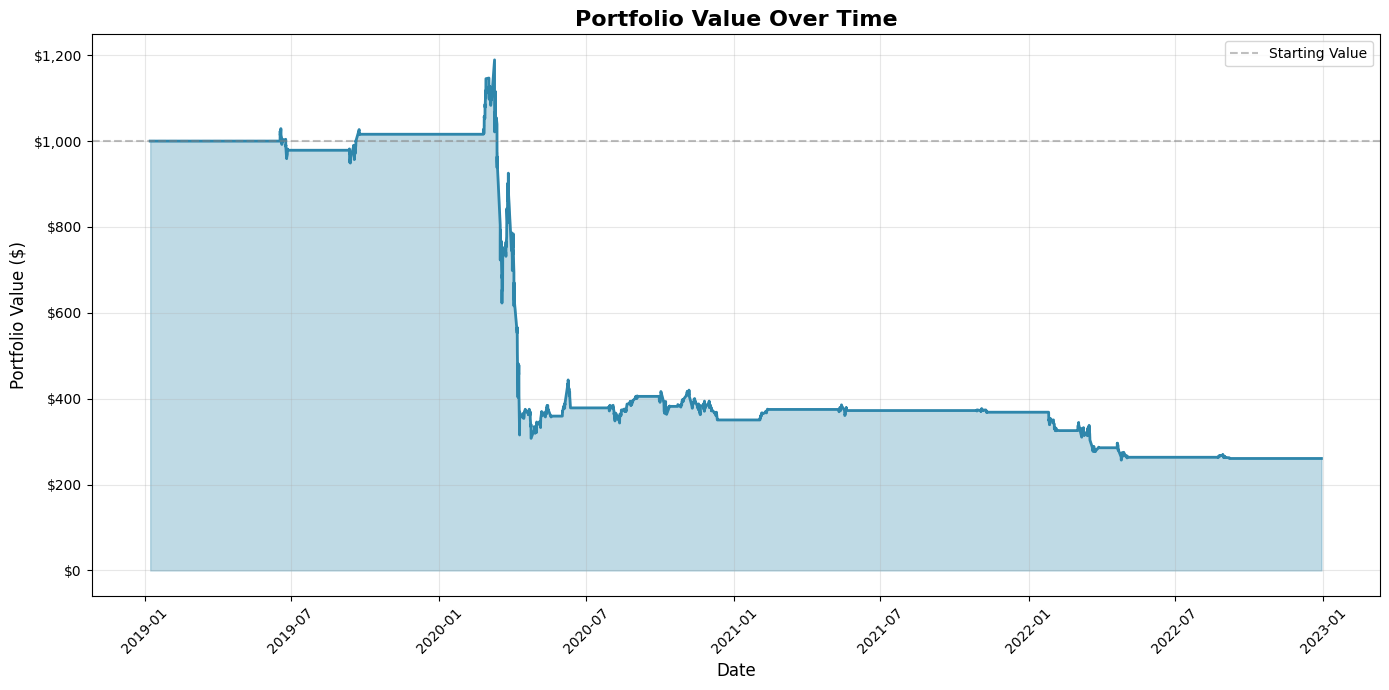

In [272]:
# Load your own data:
data_dict = {}
for symbol, data in df_first_half_pandas.groupby("symbol"):
    if symbol not in ["CRC", "GPOR", "EXE"]:
        data_dict[symbol] = data

# Run backtest
print("\n" + "="*50)
print("Running backtest...")
print("="*50)
cerebro = run_backtest(data_dict, cash=1_000, commission=0.002)
plot_portfolio_value(cerebro)

# Uncomment to run optimization
# print("\n" + "="*50)
# print("Running optimization...")
# print("="*50)
# cerebro_results = optimize_strategy(data_dict)

In [93]:
date = pd.Timestamp('2020-11-04').tz_localize('America/New_York')
df_first_half_pandas_2 = df_first_half_pandas.reset_index()
df_first_half_pandas_2[(df_first_half_pandas_2["symbol"]=="CRC") & (df_first_half_pandas_2["timestamp"] > date)].head(30)

,timestamp,symbol,Open,High,Low,Close,Volume,trade_count,VWAP,Returns,Volatility
26422,2020-11-04 09:00:00-05:00,CRC,11.54,11.59,11.18,11.47,49471.0,232.0,11.398947,-0.006066,0.011450
26444,2020-11-04 10:00:00-05:00,CRC,11.50,11.74,11.38,11.50,117733.0,761.0,11.492308,0.002616,0.010734
26466,2020-11-04 11:00:00-05:00,CRC,11.47,11.60,11.38,11.50,143784.0,119.0,11.486786,0.000000,0.010024
26488,2020-11-04 12:00:00-05:00,CRC,11.47,11.56,11.34,11.44,46810.0,196.0,11.481562,-0.005217,0.009942
26510,2020-11-04 13:00:00-05:00,CRC,11.50,11.50,11.40,11.45,10550.0,55.0,11.447778,0.000874,0.009245
26532,2020-11-04 14:00:00-05:00,CRC,11.42,11.76,11.31,11.33,95886.0,521.0,11.485714,-0.010480,0.008672
26554,2020-11-04 15:00:00-05:00,CRC,11.50,11.59,11.22,11.35,50167.0,413.0,11.444419,0.001765,0.006628
26576,2020-11-05 09:00:00-05:00,CRC,11.43,11.67,11.25,11.37,19785.0,174.0,11.447619,0.001762,0.005258
26598,2020-11-05 10:00:00-05:00,CRC,11.37,11.57,11.08,11.14,229237.0,2296.0,11.338000,-0.020229,0.007005
26620,2020-11-05 11:00:00-05:00,CRC,11.15,11.32,10.91,11.09,46851.0,280.0,11.094062,-0.004488,0.007016
